In [150]:
import sys
sys.path.append("../") # This version of the notebook is in the subfolder "notebooks" of the repo

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from typing import Union, Tuple, Callable, List, Dict

from copy import deepcopy

import importlib as imp

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

import mbt_gym
import MultiAgent
from mbt_gym.agents.Agent import Agent
from mbt_gym.agents.BaselineAgents import *
from mbt_gym.gym.helpers.generate_trajectory import *
from mbt_gym.gym.helpers.plotting import *
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.arrival_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjCriterion
from MultiAgent.MultiAgentTradingEnvironment import MultiAgentTradingEnvironment
from MultiAgent.MultiBaselineAgents import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

device = torch.device('mps')

torch.backends.mps.is_available()
torch.backends.mps.is_built()

True

In [151]:
imp.reload(MultiAgent.MultiAgentTradingEnvironment)
from MultiAgent.MultiAgentTradingEnvironment import MultiAgentTradingEnvironment

imp.reload(MultiAgent.MultiBaselineAgents)
from MultiAgent.MultiBaselineAgents import *

imp.reload(mbt_gym.gym.helpers.plotting)
imp.reload(mbt_gym.gym.helpers.generate_trajectory)
from mbt_gym.gym.helpers.plotting import *

In [32]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.5

alpha = 0.001
seed = 42
np.random.seed(seed)
timestamps = np.linspace(0, terminal_time, n_steps + 1)

num_agents: int = 1

def get_cj_multi_agent_env(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.1
    initial_price = 100
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories),
                      arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate,arrival_rate]), 
                                                           step_size=step_size, 
                                                          num_trajectories=num_trajectories),
                      fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories),
                      reward_function = CjCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return MultiAgentTradingEnvironment(**env_params)

### Random strategy

In [1]:
num_trajectories = 5
env = get_cj_multi_agent_env(num_trajectories)
agent_names: List[str] = ['English', 'Indian', 'French', 'German', 'Italian', 'Spanish', 'Russian', 'Chinese', 'Japanese', 'Korean']
initial_cash: Dict[str, float] = {agent: 1000 for agent in agent_names}
initial_cash[agent_names[0]] = 5000
initial_inventory: Dict[str, int] = {agent: int(0) for agent in agent_names}
env.register_agents(agent_names, initial_cash, initial_inventory)
agents: Dict[str, Agent] = {agent: MultiRandomAgent(env, AgentID=agent, seed=seed) for agent in agent_names}

NameError: name 'get_cj_multi_agent_env' is not defined

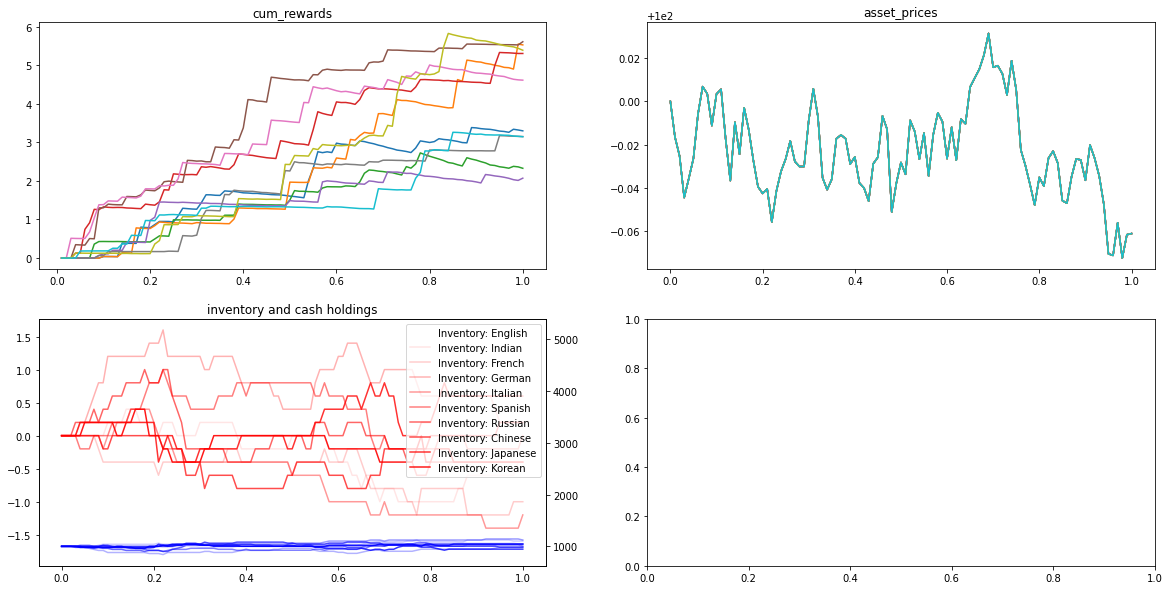

In [177]:
plot_multiagent_trajectory(env, agents, agent_names, seed)

### Fixed Strategies

In [65]:
half_spreads = [0.25] #,0.5,1,2,4
agent_names = [str(hs) for hs in half_spreads]

num_trajectories = 1
env = get_cj_multi_agent_env(num_trajectories)

initial_cash: Dict[str, float] = {agent: 1000 for agent in agent_names}
initial_cash[agent_names[0]] = 5000
initial_inventory: Dict[str, int] = {agent: int(0) for agent in agent_names}
env.register_agents(agent_names, initial_cash, initial_inventory)
agents: Dict[str, Agent] = {str(hs): FixedSpreadMultiAgent(env, half_spread=hs, AgentID=str(hs)) for hs in half_spreads}

In [262]:
performance_dict = {}

performance_dict = {}
performance_dict["observations"], performance_dict["actions"], rewards = generate_multiagent_trajectory(env, agents, seed = seed)
# rewards = np.squeeze(rewards, axis=1)
# performance_dict[hs]["cum_rewards"] = np.cumsum(rewards, axis=-1)
performance_dict["cum_rewards"] = np.cumsum(rewards)

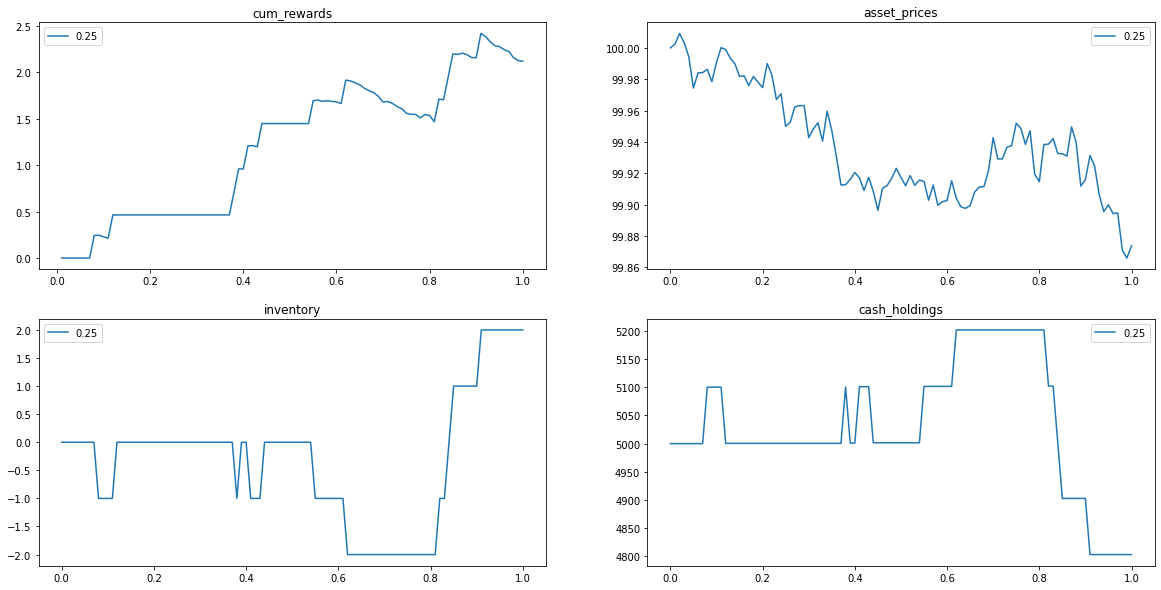

In [264]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,10))

ax1.title.set_text("cum_rewards")
ax2.title.set_text("asset_prices")
ax3.title.set_text("inventory")
ax4.title.set_text("cash_holdings")

for hs in half_spreads:
    ax1.plot(timestamps[1:],performance_dict["cum_rewards"], label = hs)
    ax2.plot(timestamps,performance_dict["observations"][:,3].reshape(-1), label = hs)
    ax3.plot(timestamps,performance_dict["observations"][:,1].reshape(-1), label = hs)
    ax4.plot(timestamps,performance_dict["observations"][:,0].reshape(-1), label = hs)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

### Policy Gradient

In [135]:
num_trajectories = 10
env = get_cj_multi_agent_env(num_trajectories)

agent_names: List[str] = ['English', 'Indian', 'French', 'German', 'Italian', 'Spanish', 'Russian', 'Chinese', 'Japanese', 'Korean']
initial_cash: Dict[str, float] = {agent: 1000 for agent in agent_names}
initial_cash[agent_names[0]] = 5000
initial_inventory: Dict[str, int] = {agent: int(0) for agent in agent_names}
env.register_agents(agent_names, initial_cash, initial_inventory)
agents: Dict[str, Agent] = {agent: PolicyGradientMultiAgent(env=env, AgentID=agent) for agent in agent_names}

for i in tqdm_notebook(range(25), desc='Epochs'):
    for id, agent in agents.items():
        # tqdm_notebook.write(f"Epoch: {i}; Agent: {id}")
        loss, reward = agent.train(agents, num_epochs=2)

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

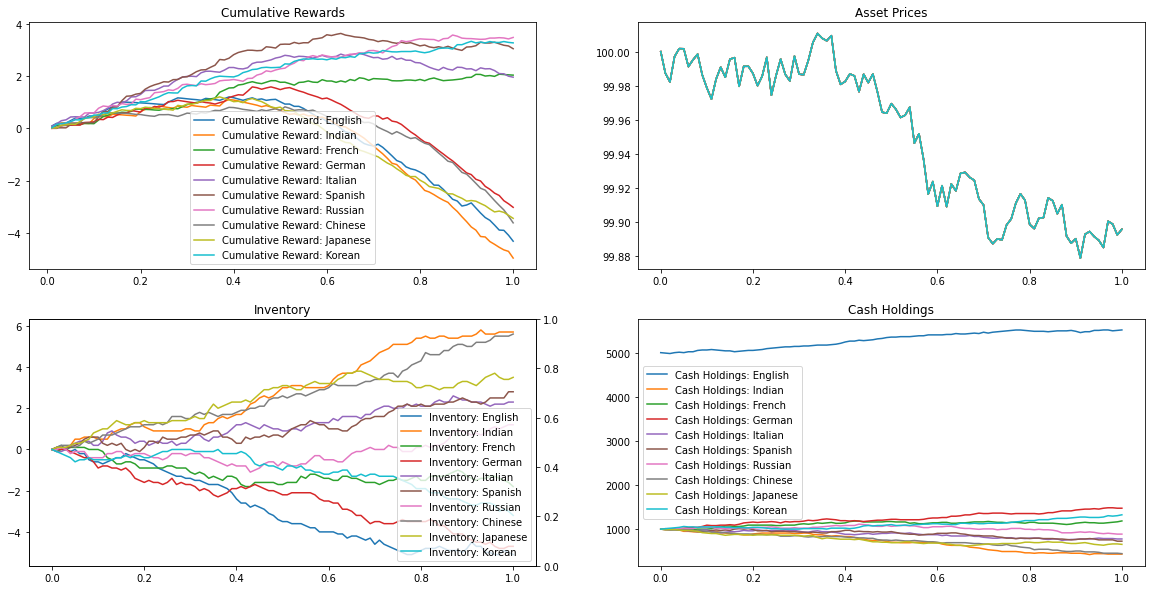

In [152]:
plot_multiagent_trajectory(env, agents, agent_names, seed)